# Imports and Initial Setup

In [168]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import datetime as dt
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# List of GCC cities
cities = ['riyadh', 'dubai', 'kuwaitcity', 'doha', 'manama', 'muscat']

# Base directory where city folders and unified files are located
base_dir = '.'  

# Dictionaries to store intermediate results
download_results = {}
upload_results = {}

# Process City Folder Data

In [171]:
# Step 1: Process city folder data (2018-2023, with some 2024 for Riyadh)
for city in cities:
    # Initialize dataframes for download and upload
    download_df = pd.DataFrame()
    upload_df = pd.DataFrame()
    
    # Path to city folder
    city_path = os.path.join(base_dir, city)
    
    # Check if folder exists
    if os.path.exists(city_path):
        # Process download files
        download_files = [f for f in os.listdir(city_path) if f.startswith(f'{city}_download_')]
        for file in download_files:
            file_path = os.path.join(city_path, file)
            df = pd.read_csv(file_path)
            download_df = pd.concat([download_df, df], ignore_index=True)
        
        # Process upload files
        upload_files = [f for f in os.listdir(city_path) if f.startswith(f'{city}_upload_')]
        for file in upload_files:
            file_path = os.path.join(city_path, file)
            df = pd.read_csv(file_path)
            upload_df = pd.concat([upload_df, df], ignore_index=True)
        
        # Convert date column to datetime and make timezone-naive
        if not download_df.empty:
            download_df['date'] = pd.to_datetime(download_df['date'], format='mixed', dayfirst=False, errors='coerce').dt.tz_localize(None)
        
        if not upload_df.empty:
            upload_df['date'] = pd.to_datetime(upload_df['date'], format='mixed', dayfirst=False, errors='coerce').dt.tz_localize(None)
        
        # Set date as index for resampling
        download_df.set_index('date', inplace=True)
        upload_df.set_index('date', inplace=True)
        
        # Resample and calculate monthly average throughput
        if not download_df.empty:
            download_monthly = download_df.resample('ME').agg({'MeanThroughputMbps': 'mean'}).rename(
                columns={"MeanThroughputMbps": f"{city}_download_mbps"})
            download_results[city] = download_monthly
        
        if not upload_df.empty:
            upload_monthly = upload_df.resample('ME').agg({'MeanThroughputMbps': 'mean'}).rename(
                columns={"MeanThroughputMbps": f"{city}_upload_mbps"})
            upload_results[city] = upload_monthly
    
    else:
        print(f"Warning: Folder {city_path} not found")

# Process Unified Download Data

In [174]:
# Step 2: Process unified download data
unified_download_file = '20231201_to_20250217.csv'

if os.path.exists(unified_download_file):
    unified_download_df = pd.read_csv(unified_download_file)
    unified_download_df['date'] = pd.to_datetime(unified_download_df['TestTime'], format='mixed', dayfirst=False, errors='coerce').dt.tz_localize(None)
    unified_download_df.set_index('date', inplace=True)
    # Sort index to ensure monotonicity
    unified_download_df = unified_download_df.sort_index()
    # Filter for 2024 data only
    unified_download_2024 = unified_download_df['2024-01-01':'2024-12-31']
    if not unified_download_2024.empty:
        # Group by ClientCity and resample
        for city in cities:
            # Normalize ClientCity to match the city list format (remove spaces, lowercase)
            city_data = unified_download_2024[unified_download_2024['ClientCity'].str.lower().str.replace(" ", "") == city]
            if not city_data.empty:
                city_monthly = city_data.resample('ME').agg({'MeanThroughputMbps': 'mean'}).rename(
                    columns={"MeanThroughputMbps": f"{city}_download_mbps"})
                if city in download_results:
                    download_results[city] = pd.concat([download_results[city], city_monthly]).sort_index()
                else:
                    download_results[city] = city_monthly
                # Diagnostic: Print date range for this city's download data
                print(f"{city.capitalize()} Download Data Range: {download_results[city].index.min()} to {download_results[city].index.max()}")

Riyadh Download Data Range: 2018-01-31 00:00:00 to 2024-12-31 00:00:00
Dubai Download Data Range: 2018-01-31 00:00:00 to 2024-12-31 00:00:00
Kuwaitcity Download Data Range: 2018-01-31 00:00:00 to 2024-12-31 00:00:00
Doha Download Data Range: 2018-01-31 00:00:00 to 2024-12-31 00:00:00
Manama Download Data Range: 2018-01-31 00:00:00 to 2024-12-31 00:00:00
Muscat Download Data Range: 2018-01-31 00:00:00 to 2024-12-31 00:00:00


# Process Unified Upload Data

In [177]:
# Step 2: Process unified upload data
unified_upload_file1 = '20221025_to_20240517.csv'
unified_upload_file2 = '20240518_to_20250217.csv'

if os.path.exists(unified_upload_file1) and os.path.exists(unified_upload_file2):
    # Process first upload file (20221025_to_20240517.csv)
    unified_upload_df1 = pd.read_csv(unified_upload_file1)
    unified_upload_df1['date'] = pd.to_datetime(unified_upload_df1['TestTime'], format='mixed', dayfirst=False, errors='coerce').dt.tz_localize(None)
    unified_upload_df1.set_index('date', inplace=True)
    unified_upload_df1 = unified_upload_df1.sort_index()
    unified_upload_2024_part1 = unified_upload_df1['2024-01-01':'2024-05-17']

    # Process second upload file (20240518_to_20250217.csv)
    unified_upload_df2 = pd.read_csv(unified_upload_file2)
    unified_upload_df2['date'] = pd.to_datetime(unified_upload_df2['TestTime'], format='mixed', dayfirst=False, errors='coerce').dt.tz_localize(None)
    unified_upload_df2.set_index('date', inplace=True)
    unified_upload_df2 = unified_upload_df2.sort_index()
    unified_upload_2024_part2 = unified_upload_df2['2024-05-18':'2024-12-31']

    # Combine the two upload datasets for 2024
    unified_upload_2024 = pd.concat([unified_upload_2024_part1, unified_upload_2024_part2]).sort_index()

    if not unified_upload_2024.empty:
        # Group by ClientCity and resample
        for city in cities:
            # Normalize ClientCity to match the city list format (remove spaces, lowercase)
            city_data = unified_upload_2024[unified_upload_2024['ClientCity'].str.lower().str.replace(" ", "") == city]
            if not city_data.empty:
                city_monthly = city_data.resample('ME').agg({'MeanThroughputMbps': 'mean'}).rename(
                    columns={"MeanThroughputMbps": f"{city}_upload_mbps"})
                if city in upload_results:
                    upload_results[city] = pd.concat([upload_results[city], city_monthly]).sort_index()
                else:
                    upload_results[city] = city_monthly
                # Diagnostic: Print date range for this city's upload data
                print(f"{city.capitalize()} Upload Data Range: {upload_results[city].index.min()} to {upload_results[city].index.max()}")

Riyadh Upload Data Range: 2018-01-31 00:00:00 to 2024-12-31 00:00:00
Dubai Upload Data Range: 2018-01-31 00:00:00 to 2024-12-31 00:00:00
Kuwaitcity Upload Data Range: 2018-01-31 00:00:00 to 2024-12-31 00:00:00
Doha Upload Data Range: 2018-01-31 00:00:00 to 2024-12-31 00:00:00
Manama Upload Data Range: 2018-01-31 00:00:00 to 2024-12-31 00:00:00
Muscat Upload Data Range: 2018-01-31 00:00:00 to 2024-12-31 00:00:00


# Filter Date Range

In [180]:
# Step 3: Filter all data to January 2019 to December 2024
for city in download_results:
    download_results[city] = download_results[city]['2019-01-01':'2024-12-31']
for city in upload_results:
    upload_results[city] = upload_results[city]['2019-01-01':'2024-12-31']

# Create Individual DataFrames and Rename Columns

In [183]:
# Step 4: Create individual DataFrames and rename columns
# Initialize DataFrames for each city
riyadh_download = pd.DataFrame()
riyadh_upload = pd.DataFrame()
dubai_download = pd.DataFrame()
dubai_upload = pd.DataFrame()
kuwaitcity_download = pd.DataFrame()
kuwaitcity_upload = pd.DataFrame()
doha_download = pd.DataFrame()
doha_upload = pd.DataFrame()
manama_download = pd.DataFrame()
manama_upload = pd.DataFrame()
muscat_download = pd.DataFrame()
muscat_upload = pd.DataFrame()

# Assign data and rename columns
for city in cities:
    if city in download_results:
        city_df = download_results[city].rename(columns={f"{city}_download_mbps": f"Throughput_{city.capitalize()}"})
        globals()[f"{city}_download"] = city_df
    if city in upload_results:
        city_df = upload_results[city].rename(columns={f"{city}_upload_mbps": f"Throughput_{city.capitalize()}"})
        globals()[f"{city}_upload"] = city_df

# Save and Display Results

In [186]:
# Step 5: Save or display results
print("Individual DataFrames have been created for each city with renamed throughput columns.")

# Save each DataFrame to CSV
for city in cities:
    if f"{city}_download" in globals():
        globals()[f"{city}_download"].to_csv(f"{city}_download_2019_2024.csv")
        print(f"{city.capitalize()} download data saved to '{city}_download_2019_2024.csv'")
    if f"{city}_upload" in globals():
        globals()[f"{city}_upload"].to_csv(f"{city}_upload_2019_2024.csv")
        print(f"{city.capitalize()} upload data saved to '{city}_upload_2019_2024.csv'")

# Example: Display sample of the data
for city in cities:
    if f"{city}_download" in globals():
        print(f"\n{city.capitalize()} Download Data Sample:")
        print(globals()[f"{city}_download"].tail())  # Using tail to check recent data including 2024
    if f"{city}_upload" in globals():
        print(f"\n{city.capitalize()} Upload Data Sample:")
        print(globals()[f"{city}_upload"].tail())  # Using tail to check recent data including 2024

Individual DataFrames have been created for each city with renamed throughput columns.
Riyadh download data saved to 'riyadh_download_2019_2024.csv'
Riyadh upload data saved to 'riyadh_upload_2019_2024.csv'
Dubai download data saved to 'dubai_download_2019_2024.csv'
Dubai upload data saved to 'dubai_upload_2019_2024.csv'
Kuwaitcity download data saved to 'kuwaitcity_download_2019_2024.csv'
Kuwaitcity upload data saved to 'kuwaitcity_upload_2019_2024.csv'
Doha download data saved to 'doha_download_2019_2024.csv'
Doha upload data saved to 'doha_upload_2019_2024.csv'
Manama download data saved to 'manama_download_2019_2024.csv'
Manama upload data saved to 'manama_upload_2019_2024.csv'
Muscat download data saved to 'muscat_download_2019_2024.csv'
Muscat upload data saved to 'muscat_upload_2019_2024.csv'

Riyadh Download Data Sample:
            Throughput_Riyadh
date                         
2024-10-31          56.876430
2024-11-30          56.213609
2024-11-30          56.213609
2024-12-3

# Graph 1 - All Cities Download Throughput (2019-2024)

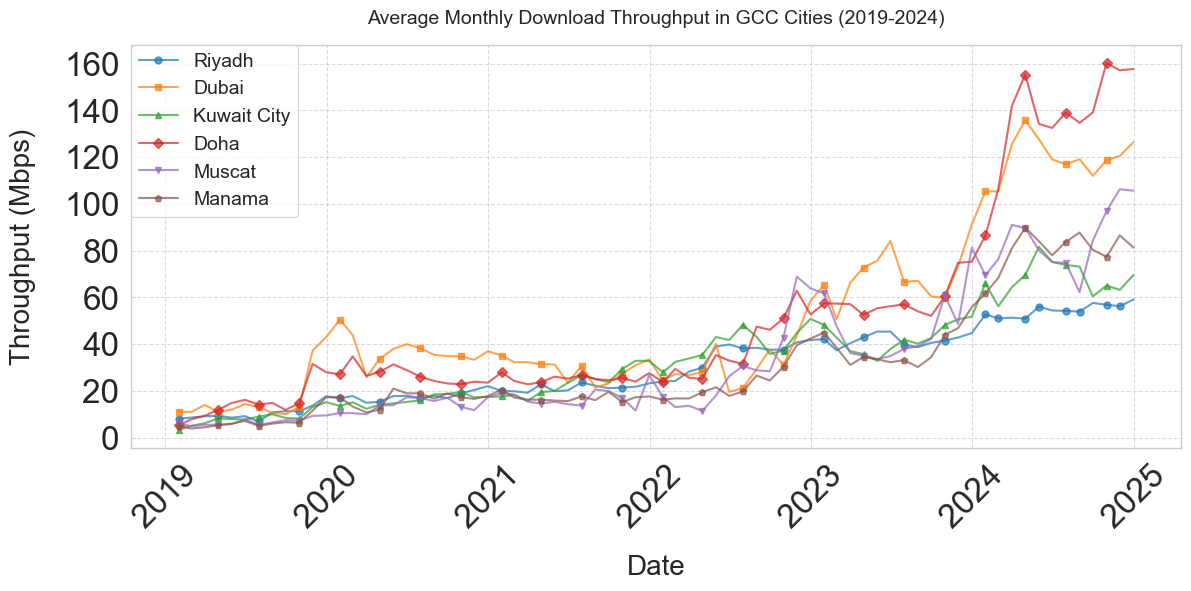

In [235]:
# Graph 1: All Cities Download Throughput (Line Plot with Markers)
plt.figure(figsize=(12, 6))  # Adjust figure size for journal paper readability

# Define marker styles for each city to differentiate in black-and-white
marker_styles = ['o', 's', '^', 'D', 'v', 'p']  # Circle, Square, Triangle Up, Diamond, Triangle Down, Pentagon

# Plot data for each city with markers
for i, city in enumerate(cities):
    if f"{city}_download" in globals():
        df = globals()[f"{city}_download"]
        plt.plot(df.index, df[f"Throughput_{city.capitalize()}"], 
                 label=f"{city.capitalize()} Download", 
                 linewidth=1.5, alpha=0.7, 
                 marker=marker_styles[i % len(marker_styles)],  # Assign a marker style
                 markersize=5,  # Marker size (small to avoid clutter)
                 markevery=3)  # Show markers every 3 points to reduce density

# Customize the plot
plt.title('Average Monthly Download Throughput in GCC Cities (2019-2024)', fontsize=14, pad=15)
plt.xlabel('Date', fontsize = 20, labelpad = 15)
plt.xticks(fontsize = 24)
plt.ylabel('Throughput (Mbps)', fontsize = 20, labelpad = 20)
plt.yticks(fontsize=24)
plt.legend(labels=['Riyadh','Dubai', 'Kuwait City', 'Doha', 'Muscat', 'Manama'],
           bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0., fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()

# Save for journal paper (high resolution)
plt.savefig('gcc_download_throughput_all_cities.png', dpi=300, bbox_inches='tight')
plt.show()

# Graph 2 - All Cities Upload Throughput (2019-2024)

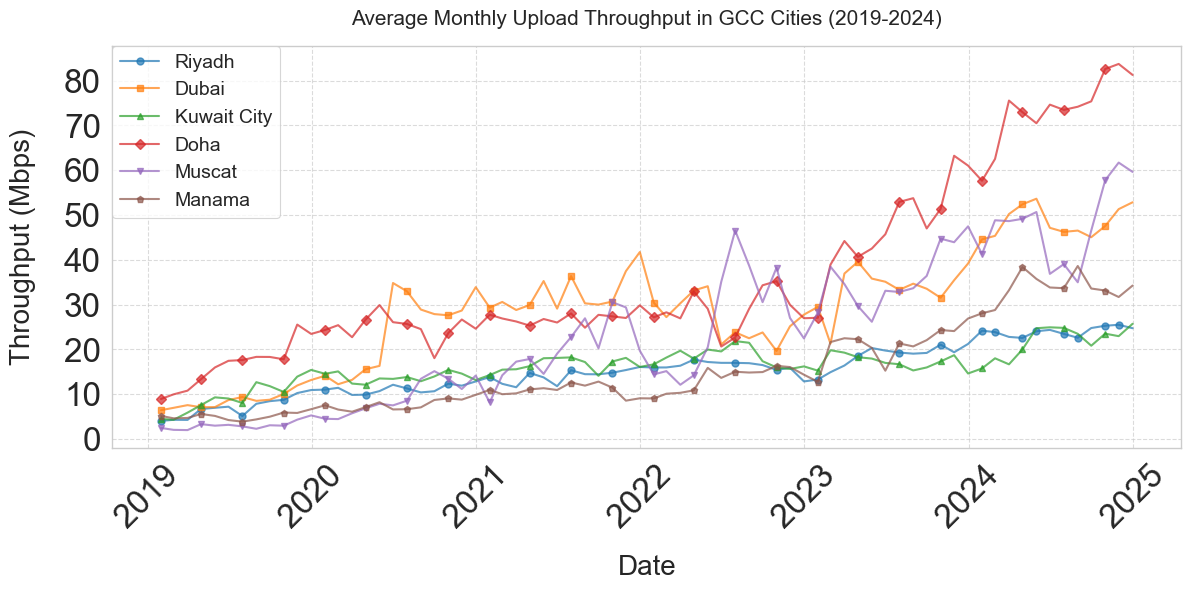

In [233]:

# Graph 2: All Cities Upload Throughput (Line Plot with Markers)
plt.figure(figsize=(12, 6))

# Define marker styles for each city to differentiate in black-and-white
marker_styles = ['o', 's', '^', 'D', 'v', 'p']  # Circle, Square, Triangle Up, Diamond, Triangle Down, Pentagon

# Plot data for each city with markers
for i, city in enumerate(cities):
    if f"{city}_upload" in globals():
        df = globals()[f"{city}_upload"]
        plt.plot(df.index, df[f"Throughput_{city.capitalize()}"], 
                 label=f"{city.capitalize()} Upload", 
                 linewidth=1.5, alpha=0.7, 
                 marker=marker_styles[i % len(marker_styles)],  # Assign a marker style
                 markersize=5,  # Marker size (small to avoid clutter)
                 markevery=3)  # Show markers every 3 points to reduce density

# Customize the plot
plt.title('Average Monthly Upload Throughput in GCC Cities (2019-2024)', fontsize=15, pad=15)
plt.xlabel('Date', fontsize = 20, labelpad = 15)
plt.xticks(fontsize = 24)
plt.ylabel('Throughput (Mbps)', fontsize = 20, labelpad = 20)
plt.yticks(fontsize=24)
plt.legend(labels=['Riyadh','Dubai', 'Kuwait City', 'Doha', 'Muscat', 'Manama'],
           bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0., fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Save for journal paper (high resolution)
plt.savefig('gcc_upload_throughput_all_cities.png', dpi=300, bbox_inches='tight')
plt.show()

# Graph 3 - Individual City Graphs (Download and Upload, 2019-2024)

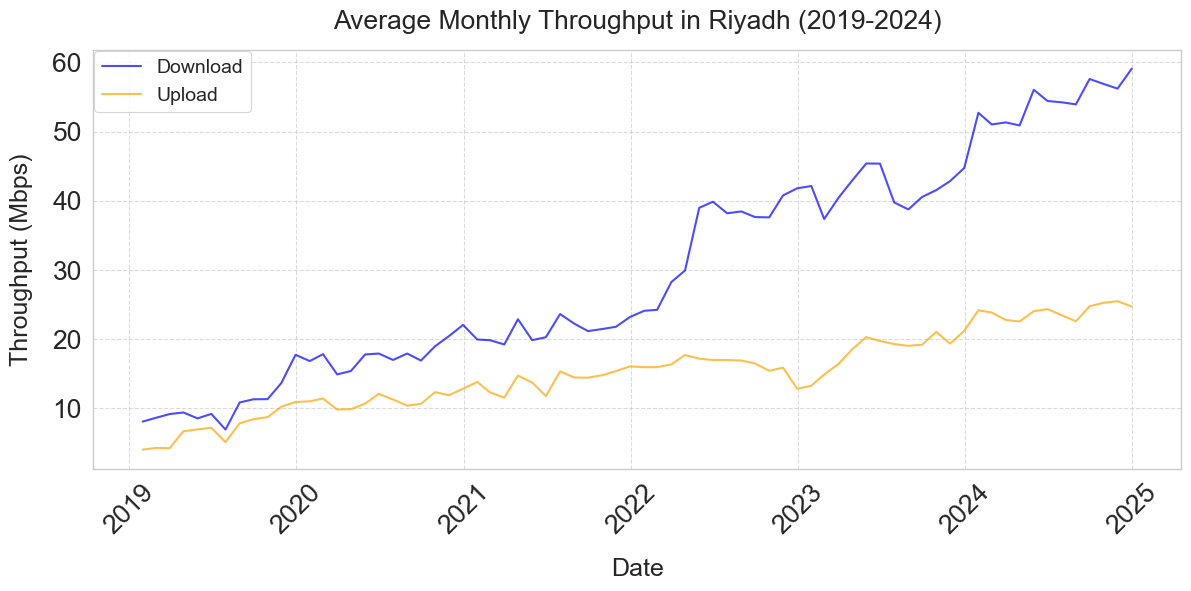

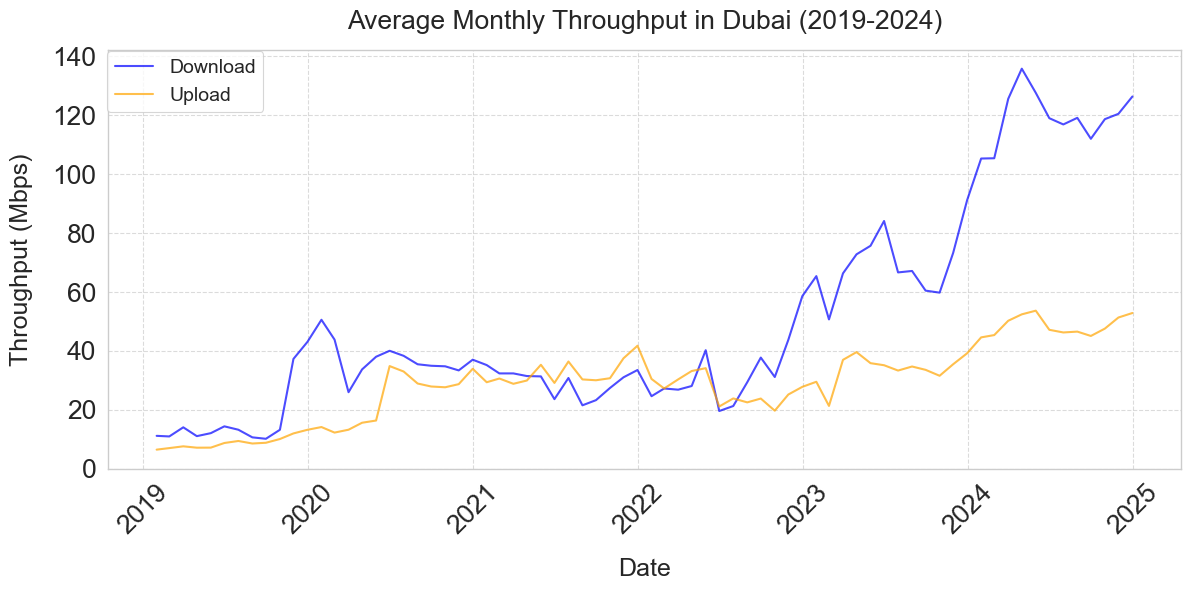

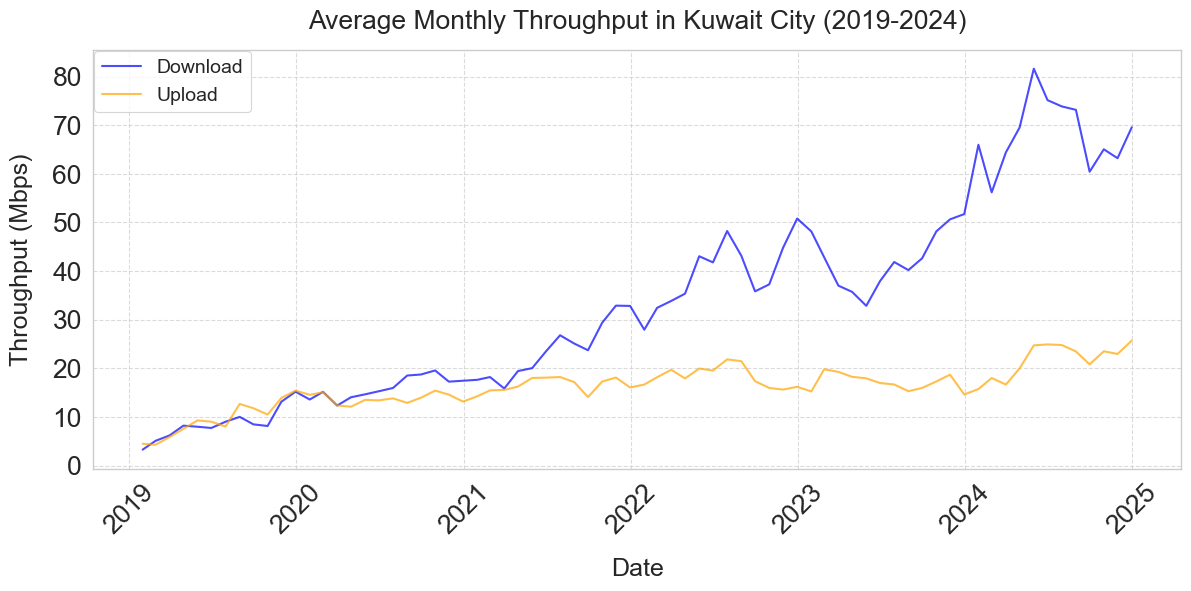

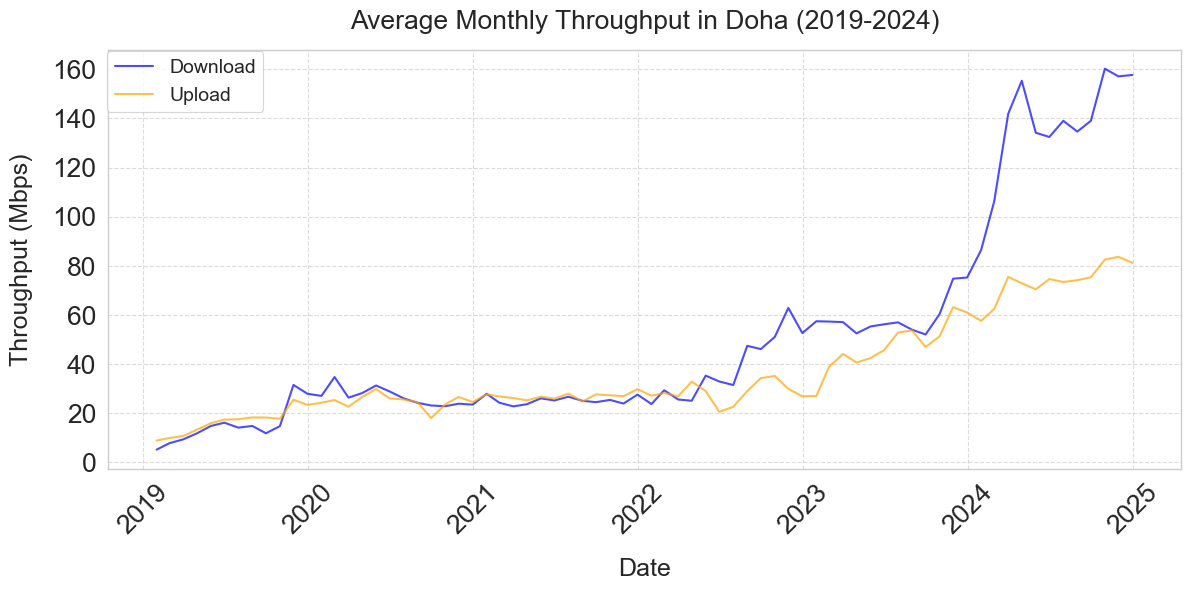

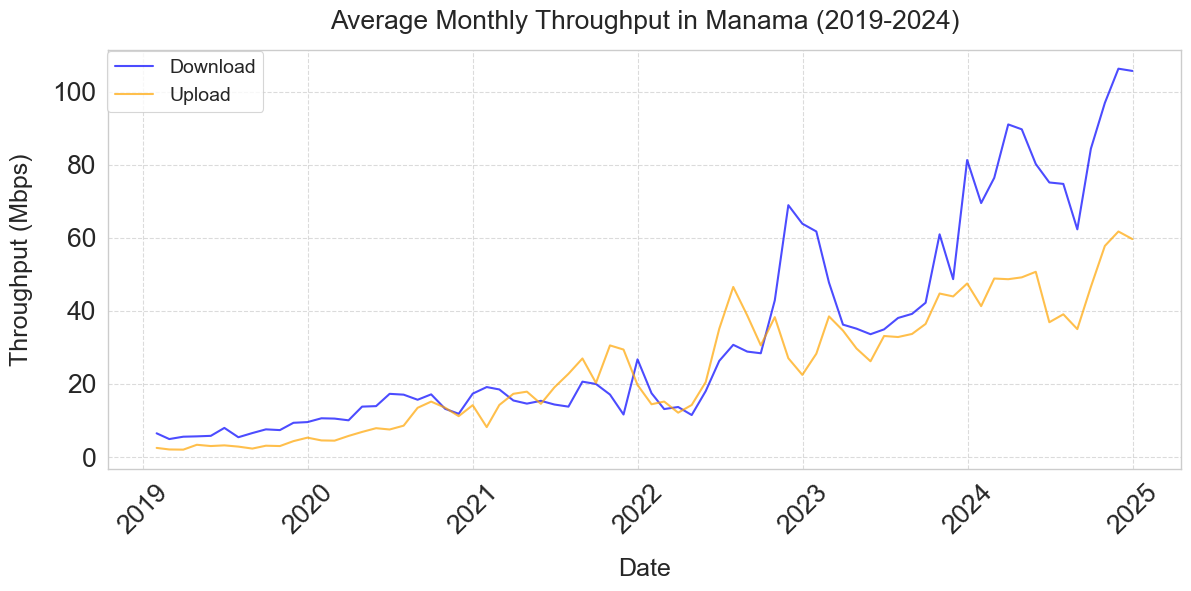

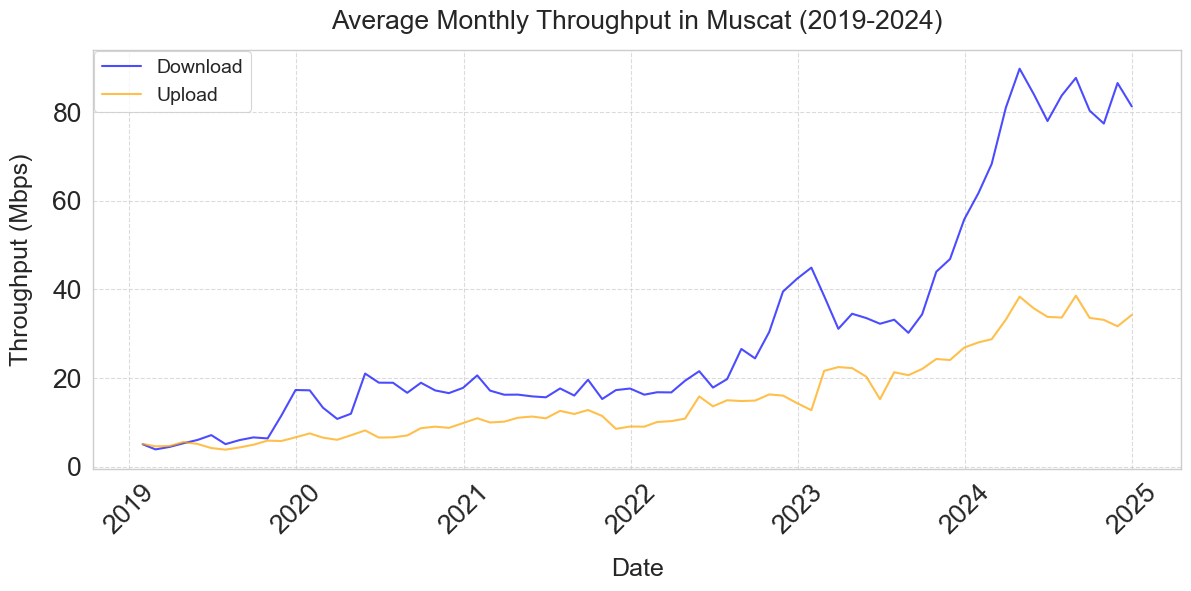

In [268]:
# Graph 3: Individual City Graphs (Download and Upload)
for city in cities:
    if f"{city}_download" in globals() and f"{city}_upload" in globals():
        # Create figure for each city
        plt.figure(figsize=(12, 6))
        
        # Plot download data
        download_df = globals()[f"{city}_download"]
        plt.plot(download_df.index, download_df[f"Throughput_{city.capitalize()}"], 
                 label=f"Download", color='blue', linewidth=1.5, alpha=0.7)
        
        # Plot upload data
        upload_df = globals()[f"{city}_upload"]
        plt.plot(upload_df.index, upload_df[f"Throughput_{city.capitalize()}"], 
                 label=f"Upload", color='orange', linewidth=1.5, alpha=0.7)
        
        # Customize the plot
        if city == "kuwaitcity":
            plt.title("Average Monthly Throughput in Kuwait City (2019-2024)", fontsize=19, pad=15)
        else:
            plt.title(f'Average Monthly Throughput in {city.capitalize()} (2019-2024)', fontsize=19, pad=15)
        plt.xlabel('Date', fontsize=18, labelpad = 14)
        plt.xticks(fontsize = 19)
        plt.ylabel('Throughput (Mbps)', fontsize=18, labelpad = 14)
        plt.yticks(fontsize = 19)
        plt.legend(fontsize=14, bbox_to_anchor=(0.154, 1.02))
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Save for journal paper (high resolution)
        plt.savefig(f'{city}_throughput_2019_2024.png', dpi=300, bbox_inches='tight')
        plt.show()

# Calculate Yearly Averages and Percentage Increases

In [231]:
###### List of GCC cities
cities = ['riyadh', 'dubai', 'kuwaitcity', 'doha', 'manama', 'muscat']

# Function to calculate yearly averages, percentage increases (2019-2024 and year-by-year)
def calculate_throughput_stats(city):
    # Initialize dictionaries for results
    yearly_download = {}
    yearly_upload = {}
    
    # Check if download and upload DataFrames exist for the city
    download_df = globals().get(f"{city}_download", pd.DataFrame())
    upload_df = globals().get(f"{city}_upload", pd.DataFrame())
    
    if not download_df.empty:
        # Resample to yearly averages (using 'YE' for year-end)
        yearly_download = download_df.resample('YE').mean().rename(columns={f"Throughput_{city.capitalize()}": "Throughput"})
        yearly_download['Year'] = yearly_download.index.year
        yearly_download = yearly_download[['Year', 'Throughput']].reset_index(drop=True)
    
    if not upload_df.empty:
        # Resample to yearly averages (using 'YE' for year-end)
        yearly_upload = upload_df.resample('YE').mean().rename(columns={f"Throughput_{city.capitalize()}": "Throughput"})
        yearly_upload['Year'] = yearly_upload.index.year
        yearly_upload = yearly_upload[['Year', 'Throughput']].reset_index(drop=True)
    
    # Calculate percentage increase from 2019 to 2024
    perc_increase_download = None
    perc_increase_upload = None
    
    if not yearly_download.empty and len(yearly_download) >= 2:
        avg_2019_download = yearly_download[yearly_download['Year'] == 2019]['Throughput'].mean()
        avg_2024_download = yearly_download[yearly_download['Year'] == 2024]['Throughput'].mean()
        if avg_2019_download > 0:  # Avoid division by zero
            perc_increase_download = ((avg_2024_download - avg_2019_download) / avg_2019_download) * 100
    
    if not yearly_upload.empty and len(yearly_upload) >= 2:
        avg_2019_upload = yearly_upload[yearly_upload['Year'] == 2019]['Throughput'].mean()
        avg_2024_upload = yearly_upload[yearly_upload['Year'] == 2024]['Throughput'].mean()
        if avg_2019_upload > 0:  # Avoid division by zero
            perc_increase_upload = ((avg_2024_upload - avg_2019_upload) / avg_2019_upload) * 100
    
    # Calculate year-by-year percentage increases
    year_by_year_download = {}
    year_by_year_upload = {}
    
    if not yearly_download.empty:
        years = sorted(yearly_download['Year'].unique())
        for i in range(1, len(years)):
            prev_year = years[i-1]
            curr_year = years[i]
            prev_avg = yearly_download[yearly_download['Year'] == prev_year]['Throughput'].mean()
            curr_avg = yearly_download[yearly_download['Year'] == curr_year]['Throughput'].mean()
            if prev_avg > 0:  # Avoid division by zero
                perc_increase = ((curr_avg - prev_avg) / prev_avg) * 100
                year_by_year_download[f"{curr_year}/{prev_year}"] = perc_increase
    
    if not yearly_upload.empty:
        years = sorted(yearly_upload['Year'].unique())
        for i in range(1, len(years)):
            prev_year = years[i-1]
            curr_year = years[i]
            prev_avg = yearly_upload[yearly_upload['Year'] == prev_year]['Throughput'].mean()
            curr_avg = yearly_upload[yearly_upload['Year'] == curr_year]['Throughput'].mean()
            if prev_avg > 0:  # Avoid division by zero
                perc_increase = ((curr_avg - prev_avg) / prev_avg) * 100
                year_by_year_upload[f"{curr_year}/{prev_year}"] = perc_increase
    
    # Print summary similar to the screenshot, including year-by-year increases
    print(f"\n{'='*50}")
    print(f"Internet Speed Statistics for {city.capitalize()}")
    print(f"{'='*50}")
    
    print(f"Average 2019 for downloads in {city.capitalize()}: {avg_2019_download:.2f} Mbps" if avg_2019_download is not None else f"No download data for {city.capitalize()} in 2019")
    print(f"Average 2024 for downloads in {city.capitalize()}: {avg_2024_download:.2f} Mbps" if avg_2024_download is not None else f"No download data for {city.capitalize()} in 2024")
    if perc_increase_download is not None:
        print(f"Percentage change from 2019 to 2024 for downloads in {city.capitalize()}: {perc_increase_download:.0f}%")
    else:
        print(f"No percentage change calculated for downloads in {city.capitalize()} due to missing data")
    
    if year_by_year_download:
        print("\nYear-by-Year Percentage Increase for Downloads:")
        for year_pair, perc in year_by_year_download.items():
            print(f"Percentage increase in {year_pair}: {perc:.0f}%")
    
    print(f"\nAverage 2019 for uploads in {city.capitalize()}: {avg_2019_upload:.2f} Mbps" if avg_2019_upload is not None else f"No upload data for {city.capitalize()} in 2019")
    print(f"Average 2024 for uploads in {city.capitalize()}: {avg_2024_upload:.2f} Mbps" if avg_2024_upload is not None else f"No upload data for {city.capitalize()} in 2024")
    if perc_increase_upload is not None:
        print(f"Percentage change from 2019 to 2024 for uploads in {city.capitalize()}: {perc_increase_upload:.0f}%")
    else:
        print(f"No percentage change calculated for uploads in {city.capitalize()} due to missing data")
    
    if year_by_year_upload:
        print("\nYear-by-Year Percentage Increase for Uploads:")
        for year_pair, perc in year_by_year_upload.items():
            print(f"Percentage increase in {year_pair}: {perc:.0f}%")
    
    # Return DataFrames for potential further use
    return yearly_download, yearly_upload

# Calculate and print stats for each city
for city in cities:
    download_yearly, upload_yearly = calculate_throughput_stats(city)

    # Optionally, save yearly averages to CSV for each city
    if not download_yearly.empty:
        download_yearly.to_csv(f"{city}_download_yearly_averages.csv", index=False)
        print(f"{city.capitalize()} download yearly averages saved to '{city}_download_yearly_averages.csv'")
    if not upload_yearly.empty:
        upload_yearly.to_csv(f"{city}_upload_yearly_averages.csv", index=False)
        print(f"{city.capitalize()} upload yearly averages saved to '{city}_upload_yearly_averages.csv'")


Internet Speed Statistics for Riyadh
Average 2019 for downloads in Riyadh: 10.40 Mbps
Average 2024 for downloads in Riyadh: 54.53 Mbps
Percentage change from 2019 to 2024 for downloads in Riyadh: 424%

Year-by-Year Percentage Increase for Downloads:
Percentage increase in 2020/2019: 71%
Percentage increase in 2021/2020: 19%
Percentage increase in 2022/2021: 64%
Percentage increase in 2023/2022: 20%
Percentage increase in 2024/2023: 30%

Average 2019 for uploads in Riyadh: 7.06 Mbps
Average 2024 for uploads in Riyadh: 24.00 Mbps
Percentage change from 2019 to 2024 for uploads in Riyadh: 240%

Year-by-Year Percentage Increase for Uploads:
Percentage increase in 2020/2019: 59%
Percentage increase in 2021/2020: 25%
Percentage increase in 2022/2021: 16%
Percentage increase in 2023/2022: 14%
Percentage increase in 2024/2023: 30%
Riyadh download yearly averages saved to 'riyadh_download_yearly_averages.csv'
Riyadh upload yearly averages saved to 'riyadh_upload_yearly_averages.csv'

Internet 

# Create Tables for Download and Upload Throughput

In [201]:
import pandas as pd

# List of GCC cities
cities = ['riyadh', 'dubai', 'kuwaitcity', 'doha', 'manama', 'muscat']

# Function to create throughput table for download or upload
def create_throughput_table(data_type):
    # Initialize lists to store data
    city_data = []
    
    # Process each city
    for city in cities:
        df = globals().get(f"{city}_{data_type}", pd.DataFrame())
        if not df.empty:
            # Calculate yearly averages using 'YE' (year-end)
            yearly = df.resample('YE').mean().rename(columns={f"Throughput_{city.capitalize()}": "Throughput"})
            yearly['Year'] = yearly.index.year
            
            # Get averages for 2019 and 2024
            avg_2019 = yearly[yearly['Year'] == 2019]['Throughput'].mean() if 2019 in yearly['Year'].values else None
            avg_2024 = yearly[yearly['Year'] == 2024]['Throughput'].mean() if 2024 in yearly['Year'].values else None
            
            # Calculate percentage increase from 2019 to 2024
            perc_increase = None
            if avg_2019 is not None and avg_2024 is not None and avg_2019 > 0:
                perc_increase = ((avg_2024 - avg_2019) / avg_2019) * 100
            
            city_data.append({
                'City': city.capitalize(),
                '2019 Average (Mbps)': avg_2019,
                '2024 Average (Mbps)': avg_2024,
                '% Increase': perc_increase
            })
    
    # Create DataFrame
    df_table = pd.DataFrame(city_data)
    
    # Drop rows with no 2024 data (if any)
    df_table = df_table.dropna(subset=['2024 Average (Mbps)'])
    
    # Sort by 2024 average throughput (descending, i.e., fastest first)
    df_table = df_table.sort_values(by='2024 Average (Mbps)', ascending=False)
    
    # Assign ranks for 2019 and 2024 based on average throughput
    df_table['2019 Rank'] = df_table['2019 Average (Mbps)'].rank(ascending=False, method='min').astype(int)
    df_table['2024 Rank'] = df_table['2024 Average (Mbps)'].rank(ascending=False, method='min').astype(int)
    
    # Reorder columns to match the screenshot
    df_table = df_table[['City', '2019 Average (Mbps)', '2024 Average (Mbps)', '% Increase', '2019 Rank', '2024 Rank']]
    
    # Format numbers for readability (two decimal places for averages, zero for percentages)
    df_table['2019 Average (Mbps)'] = df_table['2019 Average (Mbps)'].round(2)
    df_table['2024 Average (Mbps)'] = df_table['2024 Average (Mbps)'].round(2)
    df_table['% Increase'] = df_table['% Increase'].round(0).astype('Int64')  # Use Int64 to handle NaN
    
    # Replace NaN with None for cleaner display
    df_table = df_table.replace({pd.NA: None})
    
    # Print the table
    print(f"\n{'='*50}")
    print(f"Average {data_type.capitalize()} Throughput in GCC Cities (2019-2024)")
    print(f"{'='*50}")
    print(df_table.to_string(index=False))
    
    # Save to CSV for inclusion in the paper (corrected f-string)
    filename = f'gcc_{data_type}_throughput_table_2019_2024.csv'
    df_table.to_csv(filename, index=False)
    print(f"\n{filename} saved for journal paper inclusion.")

# Create tables for download and upload
create_throughput_table('download')
create_throughput_table('upload')


Average Download Throughput in GCC Cities (2019-2024)
      City  2019 Average (Mbps)  2024 Average (Mbps)  % Increase  2019 Rank  2024 Rank
      Doha                15.05               137.06         811          2          1
     Dubai                16.73               119.36         614          1          2
    Manama                 6.81                84.33        1138          6          3
    Muscat                 7.08                80.00        1031          5          4
Kuwaitcity                 8.53                68.20         699          4          5
    Riyadh                10.40                54.53         424          3          6

gcc_download_throughput_table_2019_2024.csv saved for journal paper inclusion.

Average Upload Throughput in GCC Cities (2019-2024)
      City  2019 Average (Mbps)  2024 Average (Mbps)  % Increase  2019 Rank  2024 Rank
      Doha                16.45                73.69         348          1          1
     Dubai                 8.

# Count 2024 Rows in Raw Unified Files

In [206]:
import pandas as pd
import os

# Define file paths
upload_file1 = '20221025_to_20240517.csv'
upload_file2 = '20240518_to_20250217.csv'
download_file = '20231201_to_20250217.csv'
merged_upload_output = 'merged_upload_2024.csv'
merged_download_output = 'merged_download_2024.csv'

# Function to load and filter for 2024
def load_and_filter_2024(file_path, date_column='TestTime'):
    if not os.path.exists(file_path):
        print(f"File {file_path} not found.")
        return pd.DataFrame()
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df[date_column], format='mixed', dayfirst=False, errors='coerce').dt.tz_localize(None)
    df_2024 = df[(df['date'].dt.year == 2024)]
    return df_2024

# Process Upload Data (merge two files)
if os.path.exists(upload_file1) and os.path.exists(upload_file2):
    # Load and filter for 2024
    df_upload1 = load_and_filter_2024(upload_file1)
    df_upload2 = load_and_filter_2024(upload_file2)
    
    # Merge the two DataFrames
    merged_upload = pd.concat([df_upload1, df_upload2], ignore_index=True)
    
    # Sort by TestTime for chronological order
    merged_upload = merged_upload.sort_values(by='TestTime')
    
    # Save to CSV
    merged_upload.to_csv(merged_upload_output, index=False)
    
    # Print confirmation and row counts
    print(f"Upload data for 2024 saved as '{merged_upload_output}'")
    print(f"Rows in {upload_file1} (2024): {len(df_upload1)}")
    print(f"Rows in {upload_file2} (2024): {len(df_upload2)}")
    print(f"Total rows in merged upload file (2024): {len(merged_upload)}")
else:
    print("One or both upload files not found.")

# Process Download Data (single file)
if os.path.exists(download_file):
    # Load and filter for 2024
    merged_download = load_and_filter_2024(download_file)
    
    # Sort by TestTime for chronological order
    merged_download = merged_download.sort_values(by='TestTime')
    
    # Save to CSV
    merged_download.to_csv(merged_download_output, index=False)
    
    # Print confirmation and row counts
    print(f"\nDownload data for 2024 saved as '{merged_download_output}'")
    print(f"Total rows in download file (2024): {len(merged_download)}")
else:
    print("Download file not found.")

Upload data for 2024 saved as 'merged_upload_2024.csv'
Rows in 20221025_to_20240517.csv (2024): 385434
Rows in 20240518_to_20250217.csv (2024): 625413
Total rows in merged upload file (2024): 1010847

Download data for 2024 saved as 'merged_download_2024.csv'
Total rows in download file (2024): 1101064


In [218]:
import matplotlib; print(matplotlib.__version__, matplotlib.__file__)

3.8.4 C:\Users\OPtiPlex-7090\anaconda3\Lib\site-packages\matplotlib\__init__.py
